In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt 
import pymssql
# import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator

2022-10-21 12:08:09.278050: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-21 12:08:09.278097: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
def get_data():
    df=pd.DataFrame()
    try:
        con = pymssql.connect(user='ds_rcm',password = 'mtbc@123'
                     ,host='172.16.0.32',database='mis_db',autocommit = True)
    except Exception as e:
        print('unable to make connection',e)
    cur=con.cursor()

    query = """
        SELECT CONVERT(DATE,CS.Process_Date) AS SUBMISSION_DATE,SUM(CS.Amt_Due) CHARGE_SUM
FROM CLAIMS_SUBMITTED AS CS
JOIN CLAIMS AS C ON C.Claim_No=CS.Claim_No
JOIN PATIENT AS P ON P.PATIENT_ACCOUNT=C.PATIENT_ACCOUNT AND ISNULL(P.DELETED,0)=0
JOIN PRACTICES AS PR ON PR.PRACTICE_CODE=P.PRACTICE_CODE
AND PR.IS_ACTIVE=1 AND ISNULL(PR.IS_TEST_PRACTICE,0)=0
AND ISNULL(PR.EXCLUDE_FROM_BILLING_REPORTS,0) = 0
AND PR.EMR_NAME NOT IN ('CHARTS PRO','PM STANDALONE','TESTINGPRACTICE')
AND PR.PRACTICE_CODE NOT LIKE '9090%' AND PR.PRAC_NAME NOT LIKE '%TEST%'
WHERE ISNULL(C.DELETED,0)=0 AND CONVERT(DATE,CS.Process_Date) BETWEEN '01-01-2020' AND '10-20-2022'
GROUP BY CONVERT(DATE,CS.Process_Date)
ORDER BY CONVERT(DATE,CS.Process_Date) ASC;
        """
    try:
        cur.execute(query)
        df=pd.DataFrame(cur.fetchall(),columns=[x[0] for x in cur.description])
#         print(df)
#         df.columns=df.columns.str.upper()
        con.close()
    except:
        print('Error in reading data.....')
        con.close()
    return df

In [5]:
# charges = get_data()

In [4]:
# charges.head()

In [6]:
# charges.to_csv('Submission_Charges_Data.csv')

In [7]:
charges = pd.read_csv('Submission_Charges_Data.csv')

In [8]:
charges.head()

,Unnamed: 0,SUBMISSION_DATE,CHARGE_SUM
0,0,2020-01-01,3709368.65
1,1,2020-01-02,5839172.70
2,2,2020-01-03,4235575.56
3,3,2020-01-04,218865.40
4,4,2020-01-05,2166948.41


In [9]:
len(charges)

1024

In [10]:
mean_claims = charges['CHARGE_SUM'].mean()

In [11]:
mean_claims

3893586.081437793

In [12]:
# claims.tail()

In [13]:
charges.isnull().sum()

Unnamed: 0         0
SUBMISSION_DATE    0
CHARGE_SUM         0
dtype: int64

In [14]:
charges['CHARGE_SUM'].mask( charges['CHARGE_SUM'] >= 8000000, 8000000 , inplace=True )

In [15]:
charges = charges[["SUBMISSION_DATE", "CHARGE_SUM"]]

In [16]:
charges["SUBMISSION_DATE"] = pd.to_datetime(charges["SUBMISSION_DATE"])
charges = charges.sort_values('SUBMISSION_DATE')
charges =charges.set_index("SUBMISSION_DATE")

In [17]:
charges.head()

,CHARGE_SUM
SUBMISSION_DATE,
2020-01-01,3709368.65
2020-01-02,5839172.70
2020-01-03,4235575.56
2020-01-04,218865.40
2020-01-05,2166948.41


In [18]:
charges.CHARGE_SUM = charges.CHARGE_SUM.apply(int)

<AxesSubplot:xlabel='SUBMISSION_DATE'>

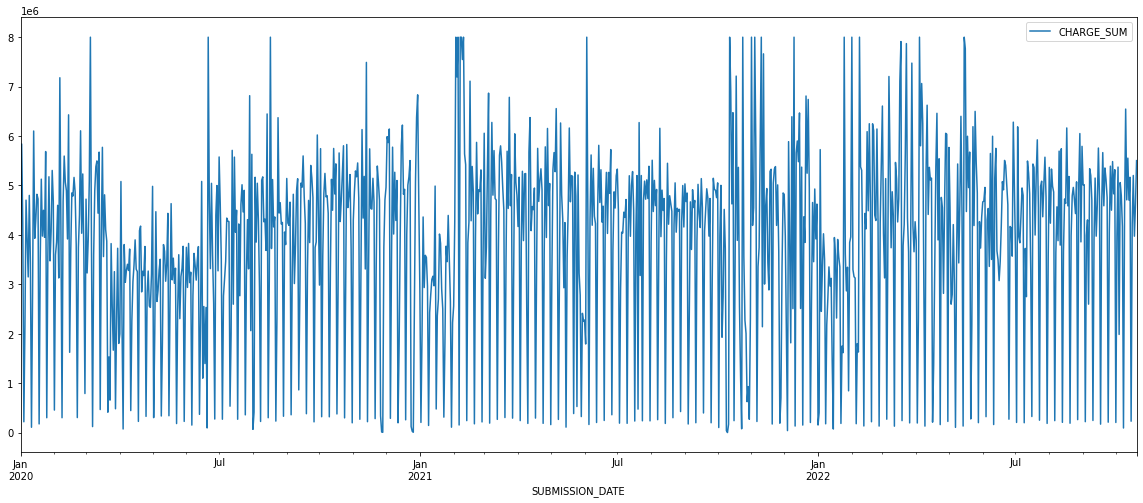

In [19]:
charges.plot(figsize=(20,8))

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [21]:
dec= seasonal_decompose(charges['CHARGE_SUM'])

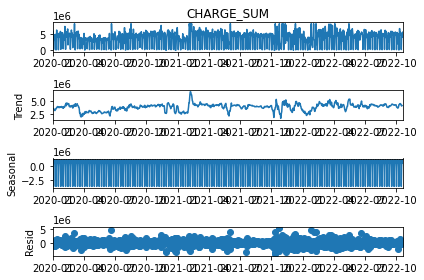

In [22]:
dec.plot();

In [23]:
train = charges.loc[:'2022-04-30']
test = charges.loc['2022-05-01':]

In [24]:
len(train)

851

In [25]:
len(test)

173

In [26]:
scaler = MinMaxScaler()

In [27]:
scaler.fit(train)

MinMaxScaler()

In [28]:
scaled_train = scaler.transform(train)

In [29]:
scaled_test = scaler.transform(test) 

In [30]:
len(scaled_train)

851

In [31]:
# define generator
n_input = 32
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=16)

In [32]:
model = Sequential()

model.add(LSTM(units =128, activation='relu', return_sequences=True, input_shape = (n_input, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next value
model.compile(optimizer='adam', loss='mse')

2022-10-21 12:09:51.183579: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-21 12:09:51.183776: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-21 12:09:51.183918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-21 12:09:51.184065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-10-21 12:09:51.184209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 32, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 32, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [34]:
# fit model
model.fit(generator,epochs=300)

Epoch 1/300
52/52 [==============================] - 10s 116ms/step - loss: 0.0905
Epoch 2/300
52/52 [==============================] - 6s 113ms/step - loss: 0.0620
Epoch 3/300
52/52 [==============================] - 6s 112ms/step - loss: 0.0619
Epoch 4/300
52/52 [==============================] - 6s 112ms/step - loss: 0.0631
Epoch 5/300
52/52 [==============================] - 6s 114ms/step - loss: 0.0611
Epoch 6/300
52/52 [==============================] - 6s 110ms/step - loss: 0.0600
Epoch 7/300
52/52 [==============================] - 6s 110ms/step - loss: 0.0632
Epoch 8/300
52/52 [==============================] - 6s 109ms/step - loss: 0.0619
Epoch 9/300
52/52 [==============================] - 6s 109ms/step - loss: 0.0608
Epoch 10/300
52/52 [==============================] - 6s 110ms/step - loss: 0.0618
Epoch 11/300
52/52 [==============================] - 6s 112ms/step - loss: 0.0625
Epoch 12/300
52/52 [==============================] - 6s 106ms/step - loss: 0.0604
Epoch 13/300

52/52 [==============================] - 6s 107ms/step - loss: 0.0232
Epoch 100/300
52/52 [==============================] - 6s 109ms/step - loss: 0.0248
Epoch 101/300
52/52 [==============================] - 5s 104ms/step - loss: 0.0236
Epoch 102/300
52/52 [==============================] - 5s 104ms/step - loss: 0.0239
Epoch 103/300
52/52 [==============================] - 6s 108ms/step - loss: 0.0241
Epoch 104/300
52/52 [==============================] - 6s 108ms/step - loss: 0.0231
Epoch 105/300
52/52 [==============================] - 6s 106ms/step - loss: 0.0225
Epoch 106/300
52/52 [==============================] - 6s 108ms/step - loss: 0.0242
Epoch 107/300
52/52 [==============================] - 6s 111ms/step - loss: 0.0235
Epoch 108/300
52/52 [==============================] - 6s 109ms/step - loss: 0.0227
Epoch 109/300
52/52 [==============================] - 6s 111ms/step - loss: 0.0227
Epoch 110/300
52/52 [==============================] - 6s 109ms/step - loss: 0.0226
Epoch 

52/52 [==============================] - 6s 107ms/step - loss: 0.0166
Epoch 197/300
52/52 [==============================] - 5s 105ms/step - loss: 0.0172
Epoch 198/300
52/52 [==============================] - 6s 107ms/step - loss: 0.0173
Epoch 199/300
52/52 [==============================] - 5s 104ms/step - loss: 0.0170
Epoch 200/300
52/52 [==============================] - 6s 109ms/step - loss: 0.0204
Epoch 201/300
52/52 [==============================] - 6s 111ms/step - loss: 0.0210
Epoch 202/300
52/52 [==============================] - 6s 110ms/step - loss: 0.0198
Epoch 203/300
52/52 [==============================] - 6s 106ms/step - loss: 0.0187
Epoch 204/300
52/52 [==============================] - 6s 107ms/step - loss: 0.0181
Epoch 205/300
52/52 [==============================] - 6s 106ms/step - loss: 0.0177
Epoch 206/300
52/52 [==============================] - 6s 109ms/step - loss: 0.0169
Epoch 207/300
52/52 [==============================] - 6s 110ms/step - loss: 0.0169
Epoch 

52/52 [==============================] - 6s 109ms/step - loss: 0.0129
Epoch 294/300
52/52 [==============================] - 6s 107ms/step - loss: 0.0112
Epoch 295/300
52/52 [==============================] - 6s 108ms/step - loss: 0.0113
Epoch 296/300
52/52 [==============================] - 5s 105ms/step - loss: 0.0122
Epoch 297/300
52/52 [==============================] - 6s 109ms/step - loss: 0.0125
Epoch 298/300
52/52 [==============================] - 6s 109ms/step - loss: 0.0124
Epoch 299/300
52/52 [==============================] - 6s 108ms/step - loss: 0.0124
Epoch 300/300
52/52 [==============================] - 6s 107ms/step - loss: 0.0109


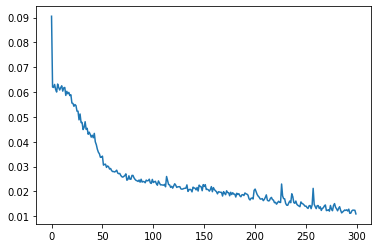

In [35]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [36]:
first_eval_batch = scaled_train[-32:]

In [37]:
# first_eval_batch

In [38]:
first_eval_batch = first_eval_batch.reshape((1,n_input,n_features))

In [39]:
model.predict(first_eval_batch)

1/1 [==============================] - 1s 608ms/step


array([[0.43746805]], dtype=float32)

In [40]:
#holding my predictions
test_predictions = []


# last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]
# reshape this to the format RNN wants (same format as TimeseriesGeneration)
current_batch = first_eval_batch.reshape((1,n_input,n_features))

#how far into the future will I forecast?

for i in range(len(test)):
    
    # One timestep ahead of historical 12 points
    current_pred = model.predict(current_batch)[0]
    
    #store that prediction
    test_predictions.append(current_pred)
    
    # UPDATE current batch o include prediction
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis= 1)

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 34ms/step


In [41]:
# test_predictions

In [42]:
true_predictions = scaler.inverse_transform(test_predictions)

In [43]:
# true_predictions

In [44]:
test['Predictions'] =true_predictions

/tmp/ipykernel_702095/4217253912.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] =true_predictions


In [45]:
test.Predictions = test.Predictions.apply(int)

/home/aaqil/aaqil_env/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [46]:
test.head()

,CHARGE_SUM,Predictions
SUBMISSION_DATE,,
2022-05-01,5769462,3500578
2022-05-02,4547032,5411580
2022-05-03,2598269,4777169
2022-05-04,2792184,5558125
2022-05-05,4208638,4309705


<AxesSubplot:xlabel='SUBMISSION_DATE'>

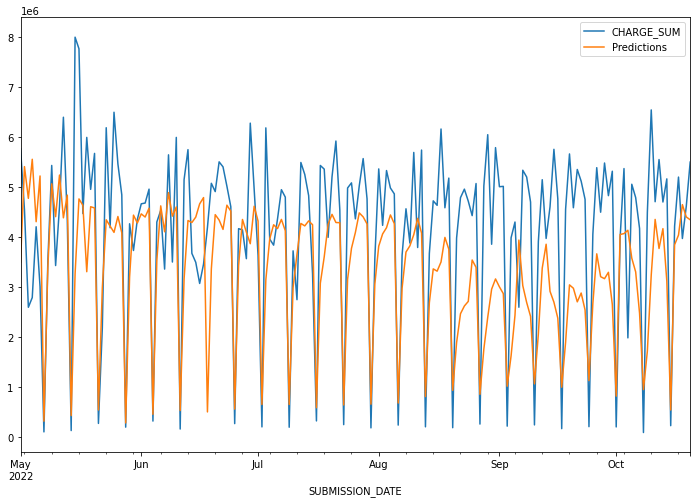

In [47]:
test.plot(figsize=(12,8))

In [48]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['CHARGE_SUM'],test['Predictions']))
print(rmse)

1531125.7898948381


In [49]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [51]:
mean_absolute_percentage_error(test['CHARGE_SUM'],test['Predictions'])

59.06012149835891